# AOSC650 Term Project
###### In this project, I will be attempting to classify different types of lunar mineralogies based on hyperspectral data from the Moon Mineralogy Mapper (M3). This will be done using a simple Multilayer Perceptron Model.

In [1]:
#Local Imports
from classifyhyspecmoon.neuralnetdata import NeuralNetData
from classifyhyspecmoon.buildNN import run_mlp,MyHyperParameters,tune_model,get_conv_model

#Remote Imports
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.font_manager as fnt_mang
import numpy as np
from matplotlib.colors import ListedColormap

Thank you for using ClassifyHySpecMoon by z-vig!



Loaded in data of shape: (239, 584, 408)
Reminder: (bands,ydimension,xdimension)


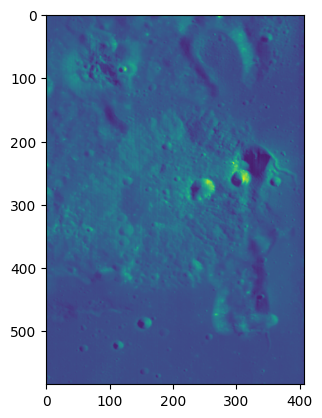

In [2]:
#Getting Raw Spectral Data and placing it in mydata ojbect.
mydata = NeuralNetData('C:/Users/zvig/.julia/dev/JENVI.jl/Data/targeted.hdf5')
print(f'Loaded in data of shape: {mydata.smoothspec.shape}')
print(f'Reminder: (bands,ydimension,xdimension)')
plt.imshow(mydata.smoothspec[1,:,:])

#### Label Creation for Supervised Learning

In [3]:
#Creating data labels based on the Spectral ANgle Mapper (SAM) technique.

# Defining reference spectra for labeling.
olpt = (200,284)
refspec1 = mydata.smoothspec[:,*olpt] #olivine
olcheck = mydata.contrem[:,*olpt]
refspec2 = mydata.smoothspec[:,500,200] #mare (South)
refspec3 = mydata.smoothspec[:,190,360] #mare (North)
refspec4 = mydata.smoothspec[:,300,200] #dome center
refspec5 = mydata.smoothspec[:,320,100] #dome flank
refspec_raw = mydata.rawspec[:,200,280]
refspec_dict = {'Olivine':(refspec1,1.2),'Mare1':(refspec2,1),'Mare2':(refspec3,0.7),'Dome1':(refspec4,1),'Dome2':(refspec5,1)} #Dictionary of tuples {str:(array,threshold)}

#Labeling data by modifying mydata object
mydata.label_data('Spectral_Angle',refspec_dict)

c:\Users\zvig\Desktop\python_code\ClassifyHySpecMoon\classifyhyspecmoon\create_labels.py:23: RuntimeWarning: invalid value encountered in arccos
  spa = 180*np.arccos(np.einsum('ijk,ijk->ij',M,I)/(np.linalg.norm(M,axis=2)*np.linalg.norm(I,axis=2)))/np.pi


In [4]:
mydata.onehot_encoding()

In [5]:
mydata.X.shape

(238272, 239)

In [6]:
# myhyp = MyHyperParameters(
#     nlyrs = 5,
#     npl = [100]*5,
#     apl = ['tanh']*5,
#     lrate = 0.001,
#     batch_size = 1000,
#     nepochs = 20
# )

In [7]:
model = get_conv_model(myhyp)
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 210, 10)           310       
                                                                 
 max_pooling1d (MaxPooling1  (None, 105, 10)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1050)              0         
                                                                 
 dense (Dense)               (None, 100)               105100    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                      

In [8]:
mydata.split_train_test()
mydata.minmax_normalization((0,1))
print(mydata.X_train.shape)

(178704, 239)


In [9]:
from sklearn.utils.class_weight import compute_class_weight
train_decoded = np.argmax(mydata.Y_train,axis=1)
class_weight_dict = dict(enumerate(compute_class_weight('balanced',
                                        classes=np.unique(train_decoded),
                                        y=train_decoded)))
nepochs=20
hist = model.fit(
    x = mydata.X_train,
    y = mydata.Y_train,
    batch_size = 2000,
    epochs=nepochs,
    validation_split=0.2,
    verbose='auto',
    class_weight = class_weight_dict
)

Epoch 1/20


286/286 [==============================] - 2s 6ms/step - loss: 0.6788 - accuracy: 0.0717 - val_loss: 0.6677 - val_accuracy: 0.0888
Epoch 2/20
286/286 [==============================] - 2s 5ms/step - loss: 0.6625 - accuracy: 0.0836 - val_loss: 0.6507 - val_accuracy: 0.0804
Epoch 3/20
286/286 [==============================] - 2s 5ms/step - loss: 0.6463 - accuracy: 0.0812 - val_loss: 0.6316 - val_accuracy: 0.0804
Epoch 4/20
286/286 [==============================] - 2s 5ms/step - loss: 0.6273 - accuracy: 0.0812 - val_loss: 0.6079 - val_accuracy: 0.0804
Epoch 5/20
286/286 [==============================] - 2s 6ms/step - loss: 0.6027 - accuracy: 0.0811 - val_loss: 0.5754 - val_accuracy: 0.0803
Epoch 6/20
286/286 [==============================] - 2s 5ms/step - loss: 0.5681 - accuracy: 0.0811 - val_loss: 0.5300 - val_accuracy: 0.0803
Epoch 7/20
286/286 [==============================] - 2s 6ms/step - loss: 0.5203 - accuracy: 0.0811 - val_loss: 0.4734 - val_accuracy: 0.0803
Epoc

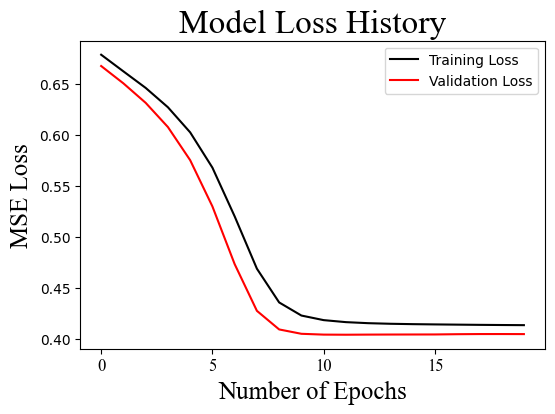

In [10]:
fancyfont = {'fontname':'Times New Roman'}
font = fnt_mang.FontProperties(family='Times New Roman',style='normal',size=10)

#Loss-validation curve
# best_model.summary()

# print(mydata.Y_train)
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(range(0,nepochs),hist.history['loss'],c='k',label='Training Loss')
ax.plot(range(0,nepochs),hist.history['val_loss'],c='r',label='Validation Loss')
ax.legend()

ax.set_title('Model Loss History',**fancyfont,fontsize=24)
ax.set_xlabel('Number of Epochs',**fancyfont,fontsize=18)
ax.set_ylabel('MSE Loss',**fancyfont,fontsize=18)
ax.set_xticks(np.arange(0,nepochs,5),labels=np.arange(0,nepochs,5),**fancyfont,fontsize=12)
# ax.set_yticks(np.arange(1.5,4.5,0.5),labels=np.arange(1.5,4.5,0.5),**fancyfont,fontsize=12)
# plt.ylim(0,0.5)

plt.savefig('G:/My Drive/Machine Learning Project/Figures/Loss_History_onehot.png',dpi=300)

In [11]:
pred_encoded = model.predict(
    x = mydata.X_test
)

1862/1862 [==============================] - 1s 741us/step


Training Data: 178704 (75%)
Testing Data: 59568 (25%)
Labeled Training Data: 59568
Predicted Test Data: 59568
dict_values([3060, 788, 12041, 4328, 4837, 7569, 26945])
dict_values([0, 0, 0, 0, 3352, 56216, 0])
0
0
59568
59568


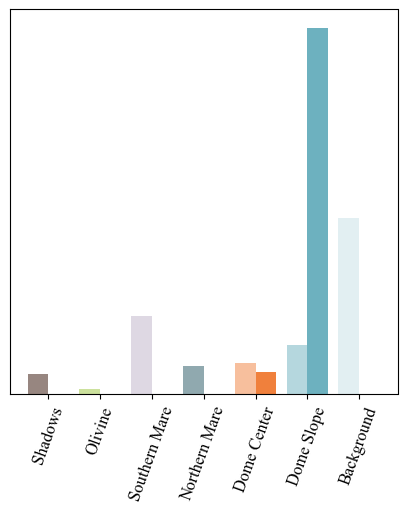

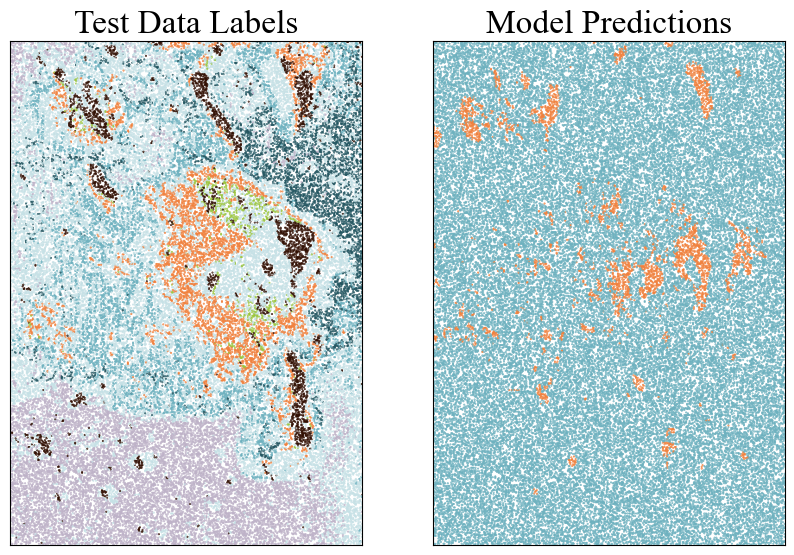

In [12]:
c = ['#310f02','#9BC53D','#BEB2C8','#225560','#F0803C','#6DB1BF','#C6E1E6']
c_map = ListedColormap(['#310f02','#9BC53D','#BEB2C8','#225560','#F0803C','#6DB1BF','#C6E1E6'])
class_names = ['Shadows','Olivine','Southern Mare','Northern Mare','Dome Center', 'Dome Slope','Background']

lab = np.argmax(mydata.Y_test,axis=1)
pred = np.argmax(pred_encoded,axis=1)


label_dist = {}
pred_dist = {}
for i in range(0,len(class_names)):
    label_dist[class_names[i]] = mydata.Y_test[lab==i].shape[0]
    pred_dist[class_names[i]] = pred[pred==i].shape[0]

print(f'Training Data: {len(mydata.Y_train)} ({len(mydata.Y_train)/mydata.num_pixels:.0%})')
print(f'Testing Data: {len(mydata.Y_test)} ({len(mydata.Y_test)/mydata.num_pixels:.0%})')
tot_label = np.array(list(label_dist.values())).sum()
tot_pred = np.array(list(pred_dist.values())).sum()
print(f'Labeled Training Data: {tot_label}')
print(f'Predicted Test Data: {tot_pred}')

print(label_dist.values())
print(pred_dist.values())

#Class Distributions
fig1,ax = plt.subplots(1,1,figsize=(5,5))
width=0.4
ax.bar(np.arange(0,len(class_names))-width/2,list(label_dist.values()),width=width,color=c,alpha=0.5)
ax.bar(np.arange(0,len(class_names))+width/2,list(pred_dist.values()),width=width,color=c)
ax.set_xticks(np.arange(0,len(class_names)))
ax.set_xticklabels(class_names,**fancyfont,fontsize=12,rotation=70)
ax.set_yticks([])

#Spatial Relations

fig2,[ax1,ax2] = plt.subplots(1,2,figsize=(10,12))
ax1.imshow(mydata.labeled_data,interpolation='none',cmap=c_map,alpha=0)
ax1.scatter(mydata.xcoord_test,mydata.ycoord_test,marker='.',s=0.8,c=lab,cmap=c_map,vmin=0,vmax=6)

ax2.imshow(mydata.labeled_data,interpolation='none',cmap=c_map,alpha=0)
ax2.scatter(mydata.xcoord_test,mydata.ycoord_test,marker='.',s=0.8,c=pred,cmap=c_map,vmin=0,vmax=6)

ax1.set_title('Test Data Labels',fontdict={'size':24,'family':'Times New Roman'})
ax2.set_title('Model Predictions',fontdict={'size':24,'family':'Times New Roman'})

ax1.set_xticks([]),ax1.set_yticks([])
ax2.set_xticks([]),ax2.set_yticks([])

print(np.count_nonzero(mydata.Y_test==6))
print(np.count_nonzero(pred==6))

print(np.array(list(label_dist.values())).sum())
print(np.array(list(pred_dist.values())).sum())

plt.savefig('G:/My Drive/Machine Learning Project/Figures/Model_Performance_good.png',dpi=800)

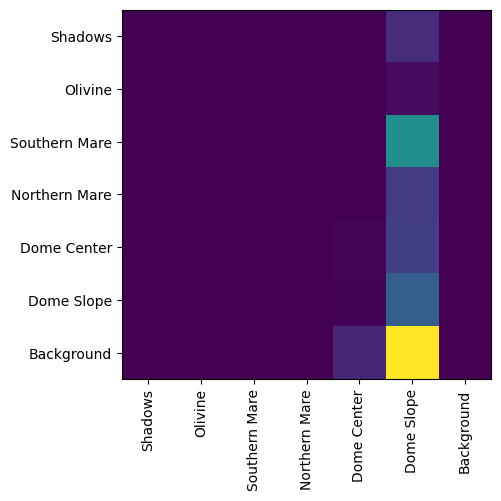

In [13]:
import sklearn.metrics

conf = sklearn.metrics.confusion_matrix(lab,pred)
plt.imshow(conf)
plt.xticks(np.arange(7),class_names,rotation=90)
plt.yticks(np.arange(7),class_names)
plt.savefig('G:/My Drive/Machine Learning Project/Figures/Confusion_Matrix.png',dpi=400)

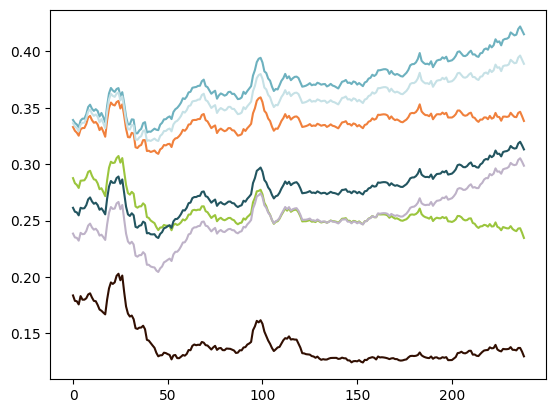

<Figure size 640x480 with 0 Axes>

In [17]:
fig,ax = plt.subplots(1,1)
for i in np.unique(pred):
    ax.plot(np.mean(mydata.X_test[pred==i,:],axis=0),color=c[i])

fig = plt.figure()